In [1]:
import gym
import time
import random
import numpy as np

from collections import deque

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

Declare a fraction of gpu, otherwise it will allocate almost all available gpu

In [2]:
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

def get_session(gpu_fraction=0.3):

    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

KTF.set_session(get_session())


Using TensorFlow backend.


Load Breakout Atari Game

In [3]:
env = gym.make( 'Breakout-v0')

[2017-09-01 19:28:39,711] Making new env: Breakout-v0


Preprocess observation
<p>1) Resize image</p>
<p>2) Crop center image - do not keep score </p>
<p>3) Grayscale image - reduce the rgb space to grayscale, save space </p>

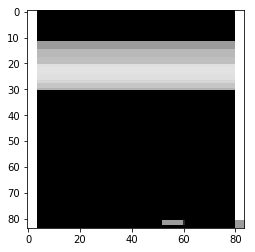

In [4]:
import cv2
import matplotlib.pyplot as plt

%matplotlib inline


def preprocess_observation( observation ):
    res = cv2.resize( observation, (84,110) )#resize to 110x84
    crop = res[18:110-8,:,:]#crop image
    grayscale = cv2.cvtColor( crop, cv2.COLOR_BGR2GRAY )#apply grayscale
    return ( grayscale )
    
observation = env.reset()#init state
    
plt.imshow( preprocess_observation( observation ), cmap='gray')

plt.show()

Build model

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers.convolutional import Conv2D
from keras.optimizers import RMSprop

model = Sequential()

#model consists of 3 convolutional layers and 2 fully connected layers

#ex. 32 filters of kernel(3,3), stride=4, input shape must be in format row, col, channels
model.add( Conv2D(32, (8,8), strides=(4,4), padding='same', input_shape=(84,84,4) ) )
model.add( Activation( 'relu' ) )

model.add(Conv2D(64, (4,4), strides=(2,2), padding='same' ) )
model.add( Activation( 'relu' ) )

model.add(Conv2D(64, (3,3), strides=(1,1), padding='same' ) )
model.add( Activation( 'relu' ) )

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add( Dense( env.action_space.n, kernel_initializer='uniform', activation='linear' ) )

learning_rate = 0.00025
model.compile(loss='mse', optimizer=RMSprop(lr=learning_rate), metrics=['accuracy'] )

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 21, 21, 32)        8224      
_________________________________________________________________
activation_1 (Activation)    (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
activation_3 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7744)              0         
__________

In [ ]:
import time

gamma = 0.99

max_reward = 0.0

start_episode = 1

epsilon = 1
epsilon_min = 0.1

exploration_steps = 1000000

epsilon_discount = ( epsilon - epsilon_min ) / exploration_steps

MAX_SIZE = 10000#capacity of deque
MIN_MIN_SIZE = 1000#min size for replay
D = deque( maxlen=MAX_SIZE )#[]

def load_deque():
    global D
    pkl_file = open( 'mydeque.pkl', 'rb')
    D = pickle.load( pkl_file )
    pkl_file.close()

def save_deque():
    output = open( 'mydeque.pkl', 'wb' )
    pickle.dump( D, output )
    output.close()

def load_dqn_model():
    global model
    from keras.models import model_from_json
    # load json and create model
    json_file = open('model_background.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights("model_background.h5")
    print("Loaded model from disk")
    #model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='mse', optimizer=RMSprop(lr=learning_rate), metrics=['accuracy'] )

import pandas as pd
import pickle

episodes = []
rewards = []
epsilons = []

def save_train():

    global episodes, rewards, epsilons

    #save [episodes, rewards, epsilons ] to csv file
    d = {'episode': episodes, 'reward': rewards, 'epsilon': epsilons}
    df = pd.DataFrame(data=d, index=None)

    if not os.path.isfile('filename.csv'):
        df.to_csv('filename.csv',header ='column_names', index=None)
    else: # else it exists so append without writing the header
        df.to_csv('filename.csv',mode = 'a',header=False, index=None)

    episodes = []
    rewards = []
    epsilons = []

    #save model to disk
    # serialize model to JSON
    model_json = model.to_json()
    with open("model_background.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model_background.h5")
    print("Saved model to disk")

    #save deque to disk
    save_deque()

def load_train():

    global start_episode, epsilon

    #get last episode and epsilon
    if not os.path.isfile('filename.csv'):
        start_episode, epsilon = 1, 1
    else: # else it exists so append without writing the header
        df = pd.read_csv( 'filename.csv')

        if len(df) == 0:
            start_episode, epsilon = 1, 1
        else:
            epsilon = list( df['epsilon'].tail(1) )[0]
            start_episode = list( df['episode'].tail(1) )[0] + 1

    if os.path.isfile('model_background.json'):
        load_dqn_model()

    if os.path.isfile('mydeque.pkl'):
        load_deque()

load_train()

#print( start_episode, epsilon )
#print( type( start_episode ) )
#print( type( epsilon ) )
#print( model.summary() )
#print( D )

total_observe = 12000#total_episodes
MIN_SIZE = 32

def replay( ):

    if len( D ) < MIN_MIN_SIZE:
        return

    samples = random.sample( D, MIN_SIZE )

    for sample in samples:

        observation, reward, done, new_observation, action = sample

        y = model.predict( observation.reshape(  ( 1, 84, 84, 4) ) )

        Q_next = model.predict( new_observation.reshape(  ( 1, 84, 84, 4) ) )

        if done:
            y[0,action] = reward
        else:
            y[0,action] = reward + gamma * ( np.max( Q_next[0]  ) )

        neural_network_observation = observation.reshape(  ( 1, 84, 84, 4) )
        model.fit( neural_network_observation, y, epochs=1, verbose=0 )
        #model.train_on_batch( neural_network_observation, y )

start = time.time()

for episode in range( start_episode, total_observe+1 ):#3600*5):

    observation = env.reset()

    observation = preprocess_observation( observation )

    recent_frames = deque(maxlen=4)

    for i in range( 4 ):
        recent_frames.append( observation )

    total_reward = 0
    
    #print( episode )

    while True:

        #env.render()

        stack_observation = np.stack(recent_frames,axis=0)

        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            Q = model.predict( stack_observation.reshape(  ( 1, 84, 84, 4) ) )[0]
            action = np.argmax( Q )

        new_observation, reward, done, info = env.step( action )

        new_observation = preprocess_observation( new_observation )#apply preprocess

        next_recent_frames = recent_frames.copy()
        next_recent_frames.append( new_observation )
        next_new_observation = np.stack(next_recent_frames,axis=0)

        D.append( ( stack_observation, reward, done, next_new_observation, action ) )

        total_reward += reward
        
        if done:
            print(  str(episode) + "Game over!", end= ' ' ),
            replay()
            episodes.append( episode )
            rewards.append( total_reward )
            epsilons.append( epsilon )
            break

        observation = new_observation

        recent_frames.append( observation )

    print( "episode " + str(episode) + " done with total reward := " + str(total_reward) )

    epsilon = max( epsilon_min, epsilon - epsilon_discount )

    if episode % 100 == 0 and episode > 1:
        save_train()

end = time.time()

print("total time is " + str( end - start ) )


1Game over! episode 1 done with total reward := 2.0
2Game over! episode 2 done with total reward := 1.0
3Game over! episode 3 done with total reward := 0.0
4Game over! episode 4 done with total reward := 0.0
5Game over! episode 5 done with total reward := 1.0
6Game over! episode 6 done with total reward := 0.0
7Game over! episode 7 done with total reward := 1.0
8Game over! episode 8 done with total reward := 1.0
9Game over! episode 9 done with total reward := 1.0
10Game over! episode 10 done with total reward := 2.0
11Game over! episode 11 done with total reward := 1.0
12Game over! episode 12 done with total reward := 2.0
13Game over! episode 13 done with total reward := 3.0
14Game over! episode 14 done with total reward := 0.0
15Game over! episode 15 done with total reward := 3.0
16Game over! episode 16 done with total reward := 4.0
17Game over! 